# Introduction to PyTorch and Poutyne

In this notebook, we train a simple fully-connected network and a simple convolutional network on MNIST. First, we train it by coding our own training loop as the PyTorch library expects of us to. Then, we use Poutyne to simplify our code.

In [23]:
# Import the package needed.
%matplotlib inline
import matplotlib.pyplot as plt

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Subset

from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne.framework import Model, ModelCheckpoint, CSVLogger, Callback, Experiment
from poutyne import torch_to_numpy

In [2]:
# Set the Numpy and PyTorch seeds so that our training are (almost) reproducible.
torch.manual_seed(42)
np.random.seed(42)

# Basis of Training a Neural Network

In **stochastic gradient descent**, a **batch** of `m` examples are drawn from the train dataset. In the so-called forward pass, these examples are passed through the neural network and an average of their loss values is done. In the backward pass, the average loss is backpropagated through the network to compute the gradient of each parameter. In practice, the `m` examples of a batch are drawn without replacement. Thus, we define one **epoch** of training being the number of batches needed to loop through the entire training dataset.

In addition to the training dataset, a **validation dataset** is used to evaluate the neural network at the end of each epoch. This validation dataset can be used to select the best model during training and thus avoiding overfitting the training set. It also can have other uses such as selecting hyperparameters

Finally, a **test dataset** is used at the end to evaluate the final model.

## Training constants

In [3]:
# Train on GPU if one is present
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

# The dataset is split 80/20 for the train and validation datasets respectively.
train_split_percent = 0.8

# The MNIST dataset has 10 classes
num_classes = 10

# Training hyperparameters
batch_size = 32
learning_rate = 0.1
num_epochs = 5

## Loading the MNIST dataset

The following loads the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. The train DataLoader shuffles the examples of the train dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./mnist/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./mnist/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
indices = list(range(num_data))
np.random.shuffle(indices)

split = math.floor(train_split_percent * num_data)

train_indices = indices[:split]
train_dataset = Subset(full_train_dataset, train_indices)

valid_indices = indices[split:]
valid_dataset = Subset(full_train_dataset, valid_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

loaders = train_loader, valid_loader, test_loader

Let's take a look at some examples of the dataset.

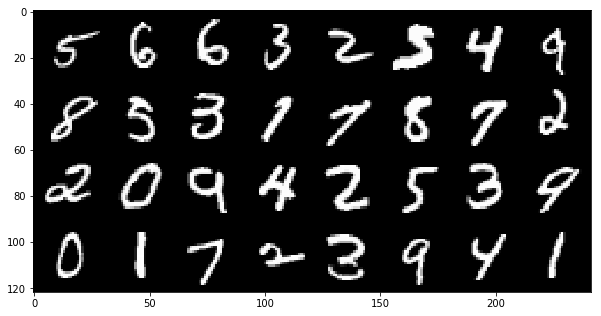

In [5]:
# Get the first batch in our train DataLoader and 
# format it in grid.
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

# Plot the images.
fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)

## Neural Network Architectures

We train a fully-connected neural network and a convolutional neural network with approximately the same number of parameters.

### Fully-connected Network
In short, the fully-connected network follows this architecture: ``Input -> [Linear -> ReLU]*3 -> Linear``. The following table shows it in details:

| Layer Type                  | Output Size |    # of Parameters   |
|-----------------------------|:-----------:|:--------------------:|
| Input                       |   1x28x28   |           0          |
| Flatten                     |  1\*28\*28  |           0          |
| **Linear with 256 neurons** |     256     | 28\*28*256 = 200,704 |
| ReLU                        |      *      |           0          |
| **Linear with 128 neurons** |     128     |   256*128 = 32,768   |
| ReLU                        |      *      |           0          |
| **Linear with 64 neurons**  |     64      |    128*64 = 8,192    |
| ReLU                        |      *      |           0          |
| **Linear with 10 neurons**  |      10     |     64*10 = 640      |

Total # of parameters of the fully-connected network: 242,304

### Convolutional Network

The convolutional neural network architecture starts with some convolution and max-pooling layers. These are then followed by fully-connected layers. We calculate the total number of parameters that the network needs. In short, the convolutional network follows this architecture: ``Input -> [Conv -> ReLU -> MaxPool]*2 -> Dropout -> Linear -> ReLU -> Dropout -> Linear``. The following table shows it in details:

| Layer Type                                     | Output Size |     # of Parameters     |
|------------------------------------------------|:-----------:|:-----------------------:|
| Input                                          |   1x28x28   |            0            |
| **Conv with 16 3x3 filters with padding of 1** |   16x28x28  |      16\*3\*3 = 144     |
| ReLU                                           |   16x28x28  |            0            |
| MaxPool 2x2                                    |   16x14x14  |            0            |
| **Conv with 32 3x3 filters with padding of 1** |   32x14x14  |      32\*3\*3 = 288     |
| ReLU                                           |   32x14x14  |            0            |
| MaxPool 2x2                                    |    32x7x7   |            0            |
| Dropout of 0.25                                |    32x7x7   |            0            |
| Flatten                                        |   32\*7\*7  |            0            |
| **Linear with 128 neurons**                    |     128     | 32\*7\*7\*128 = 200,704 |
| ReLU                                           |     128     |            0            |
| Dropout of 0.5                                 |     128     |            0            |
| **Linear with 10 neurons**                     |      10     |      128\*10 = 1280     |

Total # of parameters of the convolutional network: 202,416

In [6]:
def create_fully_connected_network():
    """
    This function returns the fully-connected network layed out above.
    """
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

def create_convolutional_network():
    """
    This function returns the convolutional network layed out above.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes)
    )

# Training the PyTorch way 

That is, doing your own training loop.

In [7]:
def pytorch_accuracy(y_pred, y_true):
    """
    Computes the accuracy for a batch of predictions
    
    Args:
        y_pred (torch.Tensor): the logit predictions of the neural network.
        y_true (torch.Tensor): the ground truths.
        
    Returns:
        The average accuracy of the batch.
    """
    y_pred = y_pred.argmax(1)
    return (y_pred == y_true).float().mean() * 100

def pytorch_train_one_epoch(pytorch_module, optimizer, loss_function):
    """
    Trains the neural network for one epoch on the train DataLoader.
    
    Args:
        pytorch_module (torch.nn.Module): The neural network to train.
        optimizer (torch.optim.Optimizer): The optimizer of the neural network
        loss_function: The loss function.
    
    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the train DataLoader.
    """
    pytorch_module.train(True)
    with torch.enable_grad():
        loss_sum = 0.
        acc_sum = 0.
        example_count = 0
        for (x, y) in train_loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = pytorch_module(x)

            loss = loss_function(y_pred, y)

            loss.backward()

            optimizer.step()

            # Since the loss and accuracy are averages for the batch, we multiply 
            # them by the the number of examples so that we can do the right 
            # averages at the end of the epoch.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc

def pytorch_test(pytorch_module, loader, loss_function):
    """
    Tests the neural network on a DataLoader.
    
    Args:
        pytorch_module (torch.nn.Module): The neural network to test.
        loader (torch.utils.data.DataLoader): The DataLoader to test on.
        loss_function: The loss function.
    
    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the DataLoader.
    """
    pytorch_module.eval()
    with torch.no_grad():
        loss_sum = 0.
        acc_sum = 0.
        example_count = 0
        for (x, y) in loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)
            
            y_pred = pytorch_module(x)
            loss = loss_function(y_pred, y)

            # Since the loss and accuracy are averages for the batch, we multiply 
            # them by the the number of examples so that we can do the right 
            # averages at the end of the test.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)
    
    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc
        
    
def pytorch_train(pytorch_module):   
    """
    This function transfers the neural network to the right device, 
    trains it for a certain number of epochs, tests at each epoch on
    the validation set and outputs the results on the test set at the
    end of training.
    
    Args:
        pytorch_module (torch.nn.Module): The neural network to train.
        
    Example:
        This function displays something like this:
        
        .. code-block:: python

            Epoch 1/5: loss: 0.5026924496193726, acc: 84.26666259765625, val_loss: 0.17258917854229608, val_acc: 94.75
            Epoch 2/5: loss: 0.13690324830015502, acc: 95.73332977294922, val_loss: 0.14024296019474666, val_acc: 95.68333435058594
            Epoch 3/5: loss: 0.08836929737279813, acc: 97.29582977294922, val_loss: 0.10380942322810491, val_acc: 96.66666412353516
            Epoch 4/5: loss: 0.06714504160980383, acc: 97.91874694824219, val_loss: 0.09626663728555043, val_acc: 97.18333435058594
            Epoch 5/5: loss: 0.05063822727650404, acc: 98.42708587646484, val_loss: 0.10017542181412378, val_acc: 96.95833587646484
            Test:
                Loss: 0.09501855444908142
                Accuracy: 97.12999725341797
    """
    print(pytorch_module)
    
    # Transfer weights on GPU if needed.
    pytorch_module.to(device)
    
    optimizer = optim.SGD(pytorch_module.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    
    for epoch in range(1, num_epochs + 1):
        # Training the neural network via backpropagation
        train_loss, train_acc = pytorch_train_one_epoch(pytorch_module, optimizer, loss_function)
        
        # Validation at the end of the epoch
        valid_loss, valid_acc = pytorch_test(pytorch_module, valid_loader, loss_function)

        print("Epoch {}/{}: loss: {}, acc: {}, val_loss: {}, val_acc: {}".format(
            epoch, num_epochs, train_loss, train_acc, valid_loss, valid_acc
        ))
    
    # Test at the end of the training
    test_loss, test_acc = pytorch_test(pytorch_module, test_loader, loss_function)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [8]:
fc_net = create_fully_connected_network()
pytorch_train(fc_net)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1/5: loss: 0.5027033858584861, acc: 84.26666666666667, val_loss: 0.17308224300046762, val_acc: 94.70833333333333
Epoch 2/5: loss: 0.13664239076307663, acc: 95.75833333333334, val_loss: 0.14514247783025105, val_acc: 95.60833333333333
Epoch 3/5: loss: 0.08835018526824812, acc: 97.25, val_loss: 0.10308833610452711, val_acc: 96.66666666666667
Epoch 4/5: loss: 0.0668404719455478, acc: 97.94166666666666, val_loss: 0.10181141934109231, val_acc: 96.90833333333333
Epoch 5/5: loss: 0.05007533495815005, acc: 98.45833333333333, val_loss: 0.09903668748401105, val_acc: 97.01666666666667
Test:
	Loss: 0.09028350643445737
	Accuracy: 97.24


In [9]:
conv_net = create_convolutional_network()
pytorch_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5: loss: 0.3875936897105227, acc: 87.59791666666666, val_loss: 0.08310377469286323, val_acc: 97.31666666666666
Epoch 2/5: loss: 0.12722661278148492, acc: 96.05625, val_loss: 0.07161106672541549, val_acc: 97.70833333333333
Epoch 3/5: loss: 0.10355726061272436, acc: 96.93541666666667, val_loss: 0.05188252531504259, val_acc: 98.36666666666666
Epoch 4/5: loss: 0.08773091599236553, acc: 97.38958333333333, val_loss:

# Training the Poutyne way

That is, only 8 lines of code with a better output.

In [10]:
def poutyne_train(pytorch_module):
    """
    This function creates a Poutyne Model, sends the Model on the specified device,
    and uses the `fit_generator` method to train the neural network. At the end,
    the `evaluate_generator` is used on the test set.
    
    Args:
        pytorch_module (torch.nn.Module): The neural network to train.
    """
    print(pytorch_module)
    
    optimizer = optim.SGD(pytorch_module.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model
    model = Model(pytorch_module, optimizer, loss_function, batch_metrics=['accuracy'])

    # Send model on GPU
    model.to(device)

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [11]:
fc_net = create_fully_connected_network()
poutyne_train(fc_net)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1/5 20.33s Step 1500/1500: loss: 0.498863, acc: 84.285417, val_loss: 0.170418, val_acc: 94.950000
Epoch 2/5 19.17s Step 1500/1500: loss: 0.135578, acc: 95.845833, val_loss: 0.113370, val_acc: 96.533333
Epoch 3/5 20.15s Step 1500/1500: loss: 0.091117, acc: 97.243750, val_loss: 0.092461, val_acc: 97.050000
Epoch 4/5 20.91s Step 1500/1500: loss: 0.067478, acc: 97.900000, val_loss: 0.089698, val_acc: 97.266667
Epoch 5/5 20.34s Step 1500/1500: loss: 0.053467, acc: 98.343750, val_loss: 0.100649, val_acc: 96.808333
Test:
	Loss: 0.09103834614804945
	Accuracy: 97.21


In [12]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5 40.40s Step 1500/1500: loss: 0.402764, acc: 86.856250, val_loss: 0.083147, val_acc: 97.441667
Epoch 2/5 42.58s Step 1500/1500: loss: 0.130895, acc: 96.027083, val_loss: 0.057410, val_acc: 98.133333
Epoch 3/5 41.55s Step 1500/1500: loss: 0.099638, acc: 96.866667, val_loss: 0.050850, val_acc: 98.425000
Epoch 4/5 41.32s Step 1500/1500: loss: 0.085509, acc: 97.429167, val_loss: 0.044986, val_acc: 98.675000
Epoch

# Poutyne Callbacks

One nice feature of Poutyne is callbacks. Callbacks allow to do actions during training of the neural network. In the following example, we use 3 callbacks. One that saves the latest weights in a file to be able to continue the optimization at the end of training if more epochs are needed. Another one that saves the best weights according to the performance on the validation dataset. Finally, another one that saves the displayed logs into TSV file.

In [13]:
def train_with_callbacks(name, pytorch_module):
    """
    In addition to the the `poutyne_train`, this function saves checkpoints and logs as described above.

    Args:
        name (str): a name used to save logs and checkpoints.
        pytorch_module (torch.nn.Module): The neural network to train.
    """
    print(pytorch_module)
    
    callbacks = [
        # Save the latest weights to be able to continue the optimization at the end for more epochs.
        ModelCheckpoint(name + '_last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

        # Save the weights in a new file when the current model is better than all previous models.
        ModelCheckpoint(name + '_best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

        # Save the losses and accuracies for each epoch in a TSV.
        CSVLogger(name + '_log.tsv', separator='\t'),
    ]
    
    train_loader, valid_loader, test_loader = loaders
    optimizer = optim.SGD(pytorch_module.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    model = Model(pytorch_module, optimizer, loss_function, batch_metrics=['accuracy'])
    model.to(device)
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [14]:
fc_net = create_fully_connected_network()
train_with_callbacks('fc', fc_net)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1/5 19.16s Step 1500/1500: loss: 0.493419, acc: 84.245833, val_loss: 0.192187, val_acc: 94.108333
Epoch 1: val_acc improved from -inf to 94.10833, saving file to fc_best_epoch_1.ckpt
Epoch 2/5 20.69s Step 1500/1500: loss: 0.138545, acc: 95.750000, val_loss: 0.113667, val_acc: 96.550000
Epoch 2: val_acc improved from 94.10833 to 96.55000, saving file to fc_best_epoch_2.ckpt
Epoch 3/5 20.32s Step 1500/1500: loss: 0.090771, acc: 97.220833, val_loss: 0.100878, val_acc: 96.950000
Epoch 3: val_acc improved from 96.55000 to 96.95000, saving file to fc_best_epoch_3.ckpt
Epoch 4/5 21.08s Step 1500/1500: loss: 0.066957, acc: 97.925000, val_loss: 0.091997, val_acc: 97.133333
Epoch 4: va

In [15]:
conv_net = create_convolutional_network()
train_with_callbacks('conv', conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5 42.68s Step 1500/1500: loss: 0.350165, acc: 88.725000, val_loss: 0.084906, val_acc: 97.366667
Epoch 1: val_acc improved from -inf to 97.36667, saving file to conv_best_epoch_1.ckpt
Epoch 2/5 42.81s Step 1500/1500: loss: 0.124853, acc: 96.200000, val_loss: 0.060569, val_acc: 98.108333
Epoch 2: val_acc improved from 97.36667 to 98.10833, saving file to conv_best_epoch_2.ckpt
Epoch 3/5 45.88s Step 1500/1500: lo

# Making Your Own Callback

While Poutyne provides a great number of predefined callbacks (see https://poutyne.org/callbacks.html), it is sometimes useful to make your own callback. 

In the following example, we want to see the effect of temperature on the optimization of our neural network. To do so, we either increase or decrease the temperature during the optimization. As one can see in the result, temperature either as no effect or has detrimental effect on the performance of the neural network. This is so because the temperature has for effect to artificially changing the learning rates. Since we have found the right learning rate, increasing or decreasing it shows no improvement on the results.

In [16]:
class CrossEntropyLossWithTemperature(nn.Module):
    """
    This loss module is the cross-entropy loss function
    with temperature. It divides the logits by a temperature
    value before computing the cross-entropy loss.
    
    Args:
        initial_temperature (float): The initial value of the temperature.
    """
    def __init__(self, initial_temperature):
        super().__init__()
        self.temperature = initial_temperature
        self.celoss = nn.CrossEntropyLoss()
        
    def forward(self, y_pred, y_true):
        y_pred = y_pred / self.temperature
        return self.celoss(y_pred, y_true)

class TemperatureCallback(Callback):
    """
    This callback multiply the loss temperature with a decay before
    each batch.
    
    Args:
        celoss_with_temp (CrossEntropyLossWithTemperature): the loss module.
        decay (float): The value of the temperature decay.
    """
    def __init__(self, celoss_with_temp, decay):
        super().__init__()
        self.celoss_with_temp = celoss_with_temp
        self.decay = decay
    
    def on_batch_begin(self, batch, logs):
        self.celoss_with_temp.temperature *= self.decay

def train_with_temperature(pytorch_module, initial_temperature, temperature_decay):
    """
    In addition to the the `poutyne_train`, this function uses a cross-entropy loss
    with temperature and decays the temperature at each batch.

    Args:
        pytorch_module (torch.nn.Module): The neural network to train.
        initial_temperature (float): The initial value of the temperature.
        decay (float): The value of the temperature decay.
    """
    print(pytorch_module)
    train_loader, valid_loader, test_loader = loaders
    optimizer = optim.SGD(pytorch_module.parameters(), lr=learning_rate)
    
    loss_function = CrossEntropyLossWithTemperature(initial_temperature)
    callbacks = [TemperatureCallback(loss_function, temperature_decay)]
    model = Model(pytorch_module, optimizer, loss_function, batch_metrics=['accuracy'])
    model.to(device)
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)
    test_loss, test_acc = model.evaluate_generator(test_loader)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [17]:
conv_net = create_convolutional_network()
# Initial temperature = 0.1
# Final temperature ≈ 0.1 * 1.0008^7500 ≈ 40.25
train_with_temperature(conv_net, 
                       initial_temperature=0.1, 
                       temperature_decay=1.0008)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5 40.01s Step 1500/1500: loss: 0.433375, acc: 86.481250, val_loss: 0.067979, val_acc: 98.016667
Epoch 2/5 40.44s Step 1500/1500: loss: 0.127288, acc: 96.435417, val_loss: 0.053940, val_acc: 98.283333
Epoch 3/5 42.61s Step 1500/1500: loss: 0.104376, acc: 96.918750, val_loss: 0.049845, val_acc: 98.575000
Epoch 4/5 41.73s Step 1500/1500: loss: 0.106108, acc: 97.102083, val_loss: 0.056210, val_acc: 98.408333
Epoch

In [18]:
conv_net = create_convolutional_network()
# Initial temperature = 40.25
# Final temperature ≈ 40.25 * 0.9992^7500 ≈ 0.1
train_with_temperature(conv_net,
                       initial_temperature=4.25, 
                       temperature_decay=0.9995)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5 40.13s Step 1500/1500: loss: 0.683385, acc: 77.008333, val_loss: 0.109731, val_acc: 96.441667
Epoch 2/5 40.91s Step 1500/1500: loss: 0.166542, acc: 94.856250, val_loss: 0.077006, val_acc: 97.591667
Epoch 3/5 44.85s Step 1500/1500: loss: 0.129828, acc: 96.193750, val_loss: 0.059286, val_acc: 98.183333
Epoch 4/5 52.82s Step 1500/1500: loss: 0.114093, acc: 96.608333, val_loss: 0.071145, val_acc: 97.858333
Epoch

# Experiment
Most of the time when using Poutyne (or even Pytorch in general), we will find ourselves in an iterative model hyperparameters finetuning loop. For efficient model search, we will usually wish to save our best performing models, their training and testing statistics and even sometimes wish to retrain an already trained model for further tuning. All of the above can be easily implemented with the flexibility of Poutyne Callbacks, but having to define and initialize each and every Callback object we wish for our model quickly feels cumbersome.

This is why Poutyne also provides an Experiment object, which aims specifically at enabling quick model iteration search, while not sacrifying on the quality of a single experiment - statistics logging, best models saving, etc. Experiment is actually a simple wrapper between a Pytorch module and Poutyne's core Callback objects for logging and saving. Given a working directory where to output the various logging files and a Pytorch module, the Experiment class reduces the whole training loop to a single line.

In [27]:
def experiment_train(pytorch_module, working_directory):
    """
    This function creates a Poutyne Experiment, trains the input module
    on the train loader and then tests its performance on the test loader.
    All training and testing statistics are saved, as well as best model
    checkpoints.
    
    Args:
        pytorch_module (torch.nn.Module): The neural network to train.
        working_directory (str): The directory where to output files to save.
    """
    print(pytorch_module)

    # Poutyne Experiment
    exp = Experiment(working_directory, pytorch_module, device=device, optimizer='sgd', task='classif')

    # Train
    exp.train(train_loader, valid_loader, epochs=5)

    # Test
    exp.test(test_loader)

In [ ]:
device = torch.device('cpu')
conv_net = create_convolutional_network()
experiment_train(conv_net, './conv_net_experiment')

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten()
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5 27.29s Step 1500/1500: loss: 1.320709, acc: 56.893750, val_loss: 0.360875, val_acc: 89.441667
Epoch 1: val_acc improved from -inf to 89.44167, saving file to ./conv_net_experiment/checkpoint_epoch_1.ckpt
Epoch 2/5 51.52s Step 1500/1500: loss: 0.384434, acc: 87.991667, val_loss: 0.192422, val_acc: 94.091667
Epoch 2: val_acc improved from 89.44167 to 94.09167, saving file to ./conv_net_experiment/checkpoint_ep